In [2]:
import cv2 as cv2
import os
import matplotlib.pyplot as plt
from PIL import Image
import easyocr
import pyocr
import numpy as np
import pandas as pd
from PIL import ImageFont, ImageDraw, Image
import seaborn as sns
from tqdm import tqdm
import sys
import re
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from skimage import filters
from skimage.measure import shannon_entropy


path = "/Users/satoshan/Library/CloudStorage/Box-Box/scan_org_charts/"
path_2010 = path + str(2010)
files = os.listdir(path_2010)
files = [f for f in files if os.path.isfile(os.path.join(path_2010, f))]
files.sort()

In [3]:
# extract organization charts
def make_data_vector (file_name):
    img = cv2.imread(file_name)
    # code detection ocr
    header = img[50:250, 10:-10]
    gray_image = cv2.cvtColor(header, cv2.COLOR_BGR2GRAY)
    _, binary_image = cv2.threshold(gray_image, 245, 255, cv2.THRESH_BINARY)
    gray_image_inv = cv2.bitwise_not(binary_image)
    blur = cv2.bilateralFilter(gray_image_inv ,9,75,75)
    pil_image = Image.fromarray(gray_image_inv)
    tools = pyocr.get_available_tools()
    tool = tools[0]
    codes = tool.image_to_string(
        pil_image,
        lang="jpn",
        builder=pyocr.builders.TextBuilder(tesseract_layout=6)
    )
    code = re.findall(r'\d+', codes)
    # cutting header and edges
    header_size = 480
    cropped_image = img[header_size:, 10:-10]

    # cutting footer
    # make figure biniary
    gray_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
    gray_image_inv = cv2.bitwise_not(gray_image)

    # footer detection
    row_sums = np.sum(gray_image_inv, axis=1) 
    threshold = 100
    empty_row_threshold = 30

    empty_row_count = 0
    footer_start = None
    for i, row_sum in enumerate(row_sums):
        if row_sum < threshold:
            empty_row_count += 1
        else:
            empty_row_count = 0
        if empty_row_count >= empty_row_threshold:
            footer_start = i - empty_row_threshold + 1
            break

    if footer_start is not None:
        final_image = cropped_image[:footer_start, :]
    else:
        final_image = cropped_image
    image_vector = final_image.flatten()
    return code,image_vector,final_image

In [4]:
# Complexity Measurement (Entropy)
def calculate_entropy(image):
    return shannon_entropy(image)

In [5]:
# cosine similarity
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [6]:
# Resize function
def process_image(image_path, size=(100, 100)):
    img = Image.open(image_path)
    img = img.resize(size)
    return np.array(img).flatten()

In [7]:
file_1 = os.path.join(path_2010, files[10])
array1 = process_image(file_1)

file_2 = os.path.join(path_2010, files[0])
array2 = process_image(file_2)

code_1, vec_1, img_1 = make_data_vector(file_1)
code_2, vec_2, img_2 = make_data_vector(file_2)

similarity = cosine_similarity(array1, array2)
complexity_entropy_1 = calculate_entropy(vec_1)
complexity_entropy_2 = calculate_entropy(vec_2)

code:  ['7012', '10135281']
entropy:  1.0746553093264972


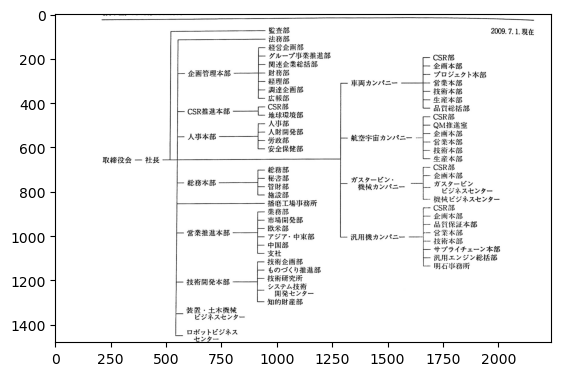

code:  ['7003', '10135249']
entropy:  0.8769213555320495


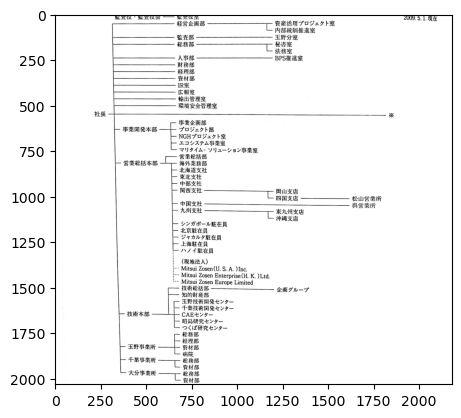

cosine similarity: 2.018439310289961e-07


In [8]:
print("code: ",code_1)
print("entropy: ",complexity_entropy_1)
plt.imshow(img_1)
plt.show()

print("code: ",code_2)
print("entropy: ",complexity_entropy_2)
plt.imshow(img_2)
plt.show()

print(f"cosine similarity: {similarity}")

In [9]:

data_list = []
pca_list = [] 
year_list = [2002, 2006, 2010]

path = "/Users/satoshan/Library/CloudStorage/Box-Box/scan_org_charts/"

for y in year_list:
    print(y)
    path_y = path + str(y)
    files = os.listdir(path_y)
    files = [f for f in files if os.path.isfile(os.path.join(path_y, f))]
    files.sort()
    for i in tqdm(range(len(files)), desc="Processing files"):
        file = os.path.join(path_y, files[i])
        array = process_image(file)
        code, vec, img = make_data_vector(file)
        complexity_entropy = calculate_entropy(vec)
        data_list.append({'year': y,'code': code, 'entropy': complexity_entropy})
        pca_array = array.reshape(1, -1)
        pca_list.append(pca_array)
       

2002


Processing files: 100%|██████████| 122/122 [00:49<00:00,  2.44it/s]


2006


Processing files: 100%|██████████| 143/143 [00:57<00:00,  2.50it/s]


2010


Processing files: 100%|██████████| 136/136 [00:54<00:00,  2.51it/s]


Text(0.5, 1.0, 'Complecity Distribution of Organization Charts')

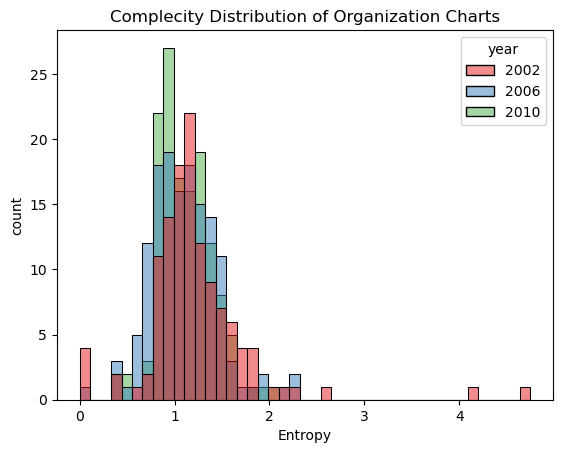

In [10]:
df = pd.DataFrame(data_list)
fig, ax = plt.subplots(1,1,dpi = 100)
ax = sns.histplot(
  data = df,
  x = "entropy",
  hue="year",
  palette='Set1'
)
ax.set_xlabel("Entropy")
ax.set_ylabel("count")
ax.set_title("Complecity Distribution of Organization Charts")

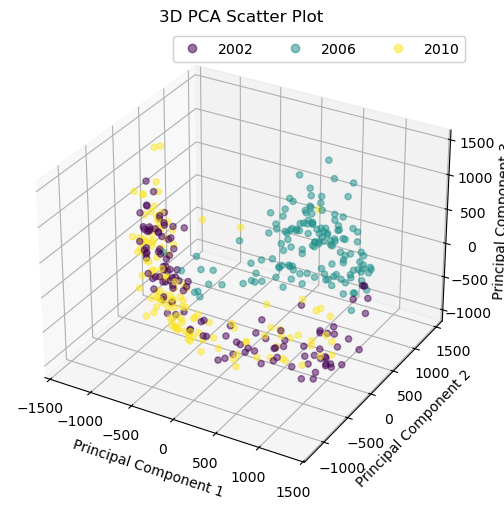

In [42]:
pca_data = np.vstack(pca_list)
pca = PCA(n_components=3)
transformed= pca.fit_transform(pca_data)

df_pca = pd.DataFrame(transformed)
df = pd.concat([df_pca,df], axis=1)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Use a colormap for year-based coloring
scatter = ax.scatter(df[0], df[1], df[2], c=df['year'], cmap='viridis', alpha=0.5)

ax.set_title('3D PCA Scatter Plot')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
handles, labels = scatter.legend_elements(prop="colors", alpha=0.5)
legend1 = ax.legend(handles, labels, loc="upper right", ncol=len(labels))
ax.add_artist(legend1)
plt.show()